This script shows how to do time series anomaly detection using Facebook (Meta) Prophet model in Python. There are three main aims: \\
· How to train a time series model using Prophet? \\
· How to make predictions using a Prophet model? \\
· How to identify outliers using a Prophet time series forecast?

In [1]:
from google.colab import drive
drive.mount('/content/drive')

df="/content/drive/MyDrive/damavis/simulated2.csv"

Mounted at /content/drive


In [ ]:
# Importing Libraries: We are importing the basic processing libraries and visualizing Numpy and pandas for data wrangling tasks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
df = pd.read_csv(df, sep=',', header=0)
df.shape
df.tail()

,timestamp,y,is_anomaly
1416,2015-01-21 07:00:00,1724.894581,0
1417,2015-01-21 08:00:00,1361.684617,0
1418,2015-01-21 09:00:00,1799.825030,0
1419,2015-01-21 10:00:00,2053.955526,0
1420,2015-01-21 11:00:00,1961.561625,0


The real time series correspond to the measurement of some real
phenomena during a given period of time, and each observation in each time series has been classified by a human as anomalous or not. The simulated signals have random scale, seasonality, trend, and noise, and outliers have been inserted at random positions. All the signals have an hourly frequency, with each row representing an observation, and the columns contain the following information:

● timestamp - the date and time of the observation

● value - value in the given timestamp of the quantity being tracked

● is_anomaly - label which is 1 if the observation is anomalous and 0 if not

In [ ]:
# Preprocessing: After performing this, the shape of data will behalf

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.shape

(1421, 3)

In [ ]:
# Data Visualization: We create an interactive line chart. On the X-axis, we have a timestamp, and on Y-axis, we have values

fig = px.line(df.reset_index(), x='timestamp', y='y', title='Analysis of anomalies')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward")
        ])
    )
)
fig.show()

In [ ]:
# Modelling: We are using Facebook Prophet to detect anomalies in time-series data. So first, we install the library

!pip uninstall pystan
!pip install pystan~=2.14
!pip install fbprophet
from fbprophet import Prophet
signal_df = df.reset_index()[['timestamp', 'y']].rename({'timestamp':'ds', 'y':'y'}, axis='columns')

Found existing installation: pystan 2.19.1.1
Uninstalling pystan-2.19.1.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pystan-2.19.1.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pystan/*
Proceed (y/n)? n
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# We separate the train and test set

train = signal_df[(signal_df['ds'] >= '2014-11-23') & (signal_df['ds'] <= '2015-01-23')]
test = signal_df[(signal_df['ds'] > '2015-01-23')]

In [ ]:
# Create Prophet model

m = Prophet(changepoint_range=0.95)  # Cut-off point for anomaly scores is a subjective decision (= 0.95 let's say)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Forecast on test data

future = m.make_future_dataframe(periods=119, freq='H')

In [ ]:
# We predict the target value on these dates. Each predicted value has a lower confidence interval and an upper confidence interval 

forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-11-23 07:00:00,1077.605651,60.448427,2160.418870
1,2014-11-23 08:00:00,1057.013371,30.421480,2078.029322
2,2014-11-23 09:00:00,1056.436588,-2.224619,2109.933964
3,2014-11-23 10:00:00,1068.556693,67.150041,2158.651659
4,2014-11-23 11:00:00,1071.491657,-4.233543,2070.355716


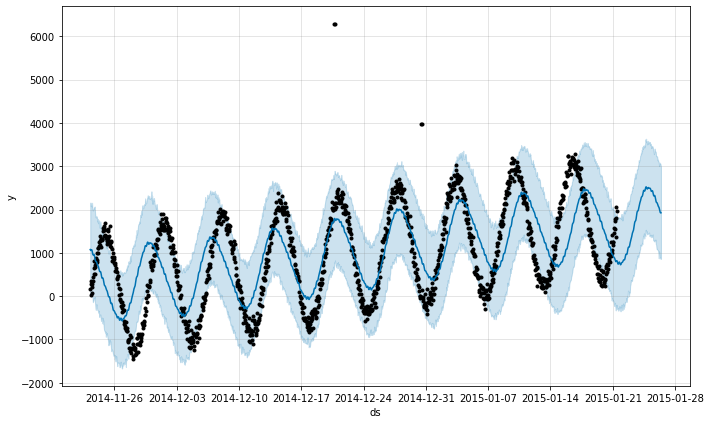

In [ ]:
# We want to see the difference between actual (black points) and predicted values (blue points)
# We create a new dataframe where we merge the actual and forecasted dataframe
# Light blue shades represent the upper confidence interval and dark blue shades represent the lower confidence interval

result = pd.concat([signal_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)


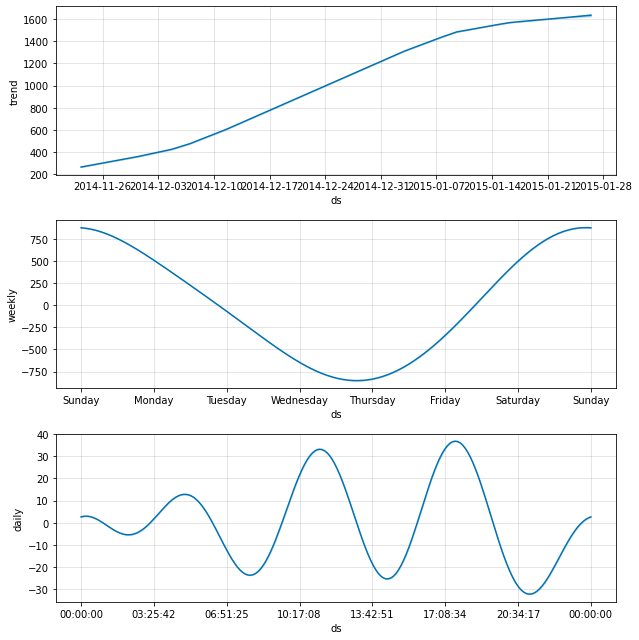

In [ ]:
# We plot a monthly, a weekly and a daily trend
# This way, the model takes weekly and daily seasonality into consideration while modelling so that it can detect outliers that look like inliers

comp = m.plot_components(forecast)

In [ ]:
# We are adding two columns to the 'result' dataframe:
# 'error' is a difference between actual and predicted values
# 'uncertainty' is the difference between upper and lower confidence intervals

result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [ ]:
# The error can be negative or positive so we take absolute of it 
# Then, we check that is it greater than the uncertainty level then most probably it is an outlier
# So, these points we get it are assigned as an anomaly in the data

result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
pred_anomaly = result['anomaly'].to_numpy()
pred_anomaly = np.where(pred_anomaly == 'No', 0, pred_anomaly)
pred_anomaly = np.where(pred_anomaly == 'Yes', 1, pred_anomaly)

match = 0
not_match = 0
match2 = 0
not_match2 = 0
is_anomaly = df['is_anomaly'].apply(lambda x: np.array(x))
print(is_anomaly)

# Precission of real anomalies captured by simulated ones in front of total real anomalies
for i in range(len(is_anomaly)):
  if is_anomaly[i] != 0:
    if is_anomaly[i] == pred_anomaly[i]:
      match += 1
    else:
      not_match += 1

#print(match)
#print(not_match)

precission = (match/(match+not_match))*100
print("The outliers detection prediction is of: {} %".format(precission))

# Precission of simulated anomalies capturing real ones in front of total simulated anomalies
for i in range(len(pred_anomaly)):
  if pred_anomaly[i] != 0:
    if is_anomaly[i] == pred_anomaly[i]:
      match2 += 1
    else:
      not_match2 += 1

#print(match2)
#print(not_match2)

precission2 = (match2/(match2+not_match2))*100
print("The model-simulated anomalies are real anomalies in a: {} %".format(precission2))


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1416    0.0
1417    0.0
1418    0.0
1419    0.0
1420    0.0
Name: is_anomaly, Length: 1421, dtype: float64
The outliers detection prediction is of: 75.0 %
The model-simulated anomalies are real anomalies in a: 100.0 %


In [ ]:
# Visualizing the anomalies in data: We create a scatter plot in which the x-axis is a timestamp, the y-axis values, and color of points vary as per anomaly

fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Analysis of anomalies')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

Conclusion 1: My model could not be used to detect outliers for future (previously unseen) data points of the series. We can do a prediction for the future. Still, outlier detection is based on the difference between actual and predicted values. We don't have actual values for the future. \\
Conclusion 2: The prediction of outliers is variable depending on the dataset. However, it works well in most of the datasets I have tried to work with. \\
Conclusion 3: Simulated data have a good performance in general; a great proportion of them show an actual outlier. \\
Conclusion 4: Real data datasets yield better results of outlier detection than simulated data datasets.
